In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import xmltodict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
from torch import nn

In [3]:
from torchvision import models, transforms

### Image Embedding

In [4]:
class ImageEmbedding(nn.Module):
    def __init__(self, channel_in: int, channel_out: int=224):
        super().__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.conv1 = nn.Conv2d(in_channels=self.channel_in,
                               out_channels=64,
                               kernel_size=4,
                               padding=1,
                               stride=2)
        self.conv2 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=4,
                               padding=1,
                               stride=2)
        self.conv3 = nn.Conv2d(in_channels=128,
                               out_channels=self.channel_out,
                               kernel_size=4,
                               padding=1,
                               stride=2)
        self.conv4 = nn.Conv2d(in_channels=self.channel_out,
                               out_channels=self.channel_out,
                               kernel_size=4,
                               padding=1,
                               stride=2)

    def forward(self, img):
        return self.conv4(self.conv3(self.conv2(self.conv1(img))))

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
img_embedding_model = ImageEmbedding(channel_in=3, channel_out=256).to(device)
img_embedding_model

ImageEmbedding(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [7]:
img = torch.randn((1, 3, 1024, 1024)).to(device)
img

tensor([[[[ 1.3939,  1.3645, -0.2191,  ...,  0.3757, -0.0429, -0.9170],
          [ 0.3738, -0.5839, -0.5420,  ...,  1.0802, -0.5724, -0.8452],
          [ 0.6498, -1.7599, -0.4489,  ..., -0.3007,  0.7269, -0.2004],
          ...,
          [-1.5015, -0.3088, -0.0236,  ..., -1.9642,  0.7235,  0.4799],
          [-0.1223,  0.8448, -1.0877,  ...,  0.4197,  2.0173, -0.3181],
          [-0.9577, -0.1982, -0.0977,  ...,  0.8869,  0.1909,  0.3012]],

         [[-0.0178,  0.6976, -0.9807,  ..., -0.8530, -0.0378,  0.0185],
          [-0.2429,  0.3587, -0.2181,  ..., -0.0097,  1.3327, -2.3977],
          [-0.3180,  1.1927,  0.9193,  ...,  0.1100,  1.8125,  1.2613],
          ...,
          [ 0.5975,  0.6254,  0.0467,  ...,  2.3668, -0.0201, -1.2788],
          [-1.6190,  2.0827, -0.0704,  ..., -0.6007, -0.9901, -2.3006],
          [ 2.6524,  1.2648, -1.0236,  ...,  0.4032,  0.3833,  1.0141]],

         [[ 0.3597, -0.3516, -0.5171,  ...,  2.0476,  1.2830,  1.6134],
          [-1.2107,  0.7362,  

In [8]:
img_embedding_model(img).shape

d:\Side_project\MedSAM\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 256, 64, 64])

In [9]:
transform = {'img': transforms.Compose([transforms.Resize(size=(1024, 1024)),
                                        transforms.ToTensor()]),
             'mask':transforms.Compose([transforms.Resize(size=(256, 256)),
                                        transforms.ToTensor()])}

In [10]:
from pathlib import Path
from PIL import Image
data_root = r'D:\Side_project\MedSAM\data\gastrointestinal'


#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root, transform=None, device=device):
        self.data_root = Path(data_root)
        self.transform = transform
        self.mask = list(Path(self.data_root / 'mask').glob('*.png'))

        # TODO: do feature extractor
        self.imgs = list(Path(self.data_root / 'images').glob('*.png'))
        
        self.bbox_xml = list(Path(self.data_root / 'bbox').glob('*.xml'))
        # print(self.mask, self.imgs, self.bbox_xml)
    
    def __len__(self):
        assert len(self.mask) == len(self.imgs) == len(self.bbox_xml), "The length of bbox, imgs, mask not match!"
        return len(self.mask)

    def __getitem__(self, index):
        img = Image.open(self.imgs[index])  # 224*224*3
        img = transform['img'](img)  # 3*512*512
        # print(f'{img_embedding.shape=}')


        
        mask = Image.open(self.mask[index])  # 1*224*224
        mask = transform['mask'](mask)  # 1*256*256
        torch.where(mask > 0)
        # print(f'{mask.shape=}')

        xml_data = self.convert_xml_2_dict(self.bbox_xml[index])
        
        bbox_dict = {k:int(v) for k, v in xml_data['annotation']['object']['bndbox'].items()}

        W, H = 256, 256
        ratio = 256/224
        # print(f'W:{W}, H:{H}')

        # plt.imshow(img)
        # plt.scatter(bbox_dict['xmin'], bbox_dict['ymin'], color='r', marker='o')
        # plt.scatter(bbox_dict['xmax'], bbox_dict['ymax'], color='b', marker='o')
        # print(f"Original position: {bbox_dict['xmin'], bbox_dict['ymin'], bbox_dict['xmax'], bbox_dict['ymax']}")


        x_min = max(0, bbox_dict['xmin']*ratio - np.random.randint(0, 20))
        x_max = min(W, bbox_dict['xmax']*ratio + np.random.randint(0, 20))
        y_min = max(0, bbox_dict['ymin']*ratio - np.random.randint(0, 20))
        y_max = min(H, bbox_dict['ymax']*ratio + np.random.randint(0, 20))

        bboxes = torch.Tensor(np.array([x_min, y_min, x_max, y_max]))
        # print(f'{bboxes.shape=}')
        # print(f'perturbation position: {xmin, ymin, xmax, ymax}')

        # plt.scatter(x_min, y_min, color='r', marker='*')
        # plt.scatter(x_max, y_max, color='b', marker='*')

        return (img, # img, 3*512*512
                mask, # mask, 1*256*256
                bboxes)  # bbox, 4
    

        # y_indices, x_indices = np.where(gt2D > 0)
        # x_min, x_max = np.min(x_indices), np.max(x_indices)
        # y_min, y_max = np.min(y_indices), np.max(y_indices)
        # # add perturbation to bounding box coordinates
        # H, W = gt2D.shape
        # x_min = max(0, x_min - np.random.randint(0, 20))
        # x_max = min(W, x_max + np.random.randint(0, 20))
        # y_min = max(0, y_min - np.random.randint(0, 20))
        # y_max = min(H, y_max + np.random.randint(0, 20))
        # bboxes = np.array([x_min, y_min, x_max, y_max])
        # # convert img embedding, mask, bounding box to torch tensor
        # return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

    def convert_xml_2_dict(self, xml_file_path):
        with open(xml_file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
            xml_dict = xmltodict.parse(xml_content)
            return xml_dict

In [11]:
dataset = NpzDataset(data_root, transform=transform)

In [12]:
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([3, 1024, 1024]), torch.Size([1, 256, 256]))

In [13]:
demo_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
img_embed, gt2D, bboxes = next(iter(demo_dataloader))
# img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")

img_embed.shape=torch.Size([1, 3, 1024, 1024]), gt2D.shape=torch.Size([1, 1, 256, 256]), bboxes.shape=torch.Size([1, 4])


In [14]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# %% set up model for fine-tuning 
# train data path
npz_tr_path = data_root
work_dir = Path('./work_dir')
task_name = 'demo2D_ICIP_2'
# prepare SAM model
model_type = 'vit_b'
checkpoint = r'D:\Side_project\MedSAM\work_dir\MedSAM\medsam_vit_b.pth'
device = 'cuda'

model_save_path:Path = work_dir / task_name
model_save_path.mkdir(parents=True, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [15]:
class SAMWrapper(nn.Module):
    def __init__(self, sam_model) -> None:
        super().__init__()
        self.pretrain_model = ImageEmbedding(channel_in=3, channel_out=256).to(device)
        self.sam_model = sam_model

    def forward(self, img, sparse_embeddings, dense_embeddings):

        img_embedding = self.pretrain_model(img).to(device)
        mask_predictions, _ = self.sam_model.mask_decoder(
            image_embeddings=img_embedding, # (B, 256, 64, 64) (B, C, H, W)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64) (B, C, H, W)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64) (B, C, H, W)
            multimask_output=False,
        )
        return mask_predictions, _

In [17]:
sam_wapper = SAMWrapper(sam_model=sam_model).to(device)
sam_wapper

SAMWrapper(
  (pretrain_model): ImageEmbedding(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (sam_model): Sam(
    (image_encoder): ImageEncoderViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (lin1): Linear(in_features=768,

In [20]:
#%% train
from timeit import default_timer as timer
num_epochs = 1
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

start_time = timer()
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (img, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_wapper.sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_wapper.sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )

        img = img.to(device)

        # predicted masks
        mask_predictions, _ = sam_wapper(img, sparse_embeddings, dense_embeddings)

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_wapper.sam_model.state_dict(), (model_save_path / 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_wapper.sam_model.state_dict(), (model_save_path / 'sam_model_best.pth'))

end_time = timer()

print(f'Training time: {end_time - start_time:.3f}')

100%|██████████| 5/5 [00:00<00:00,  9.64it/s]


EPOCH: 0, Loss: 0.21449514478445053
Training time: 1.301


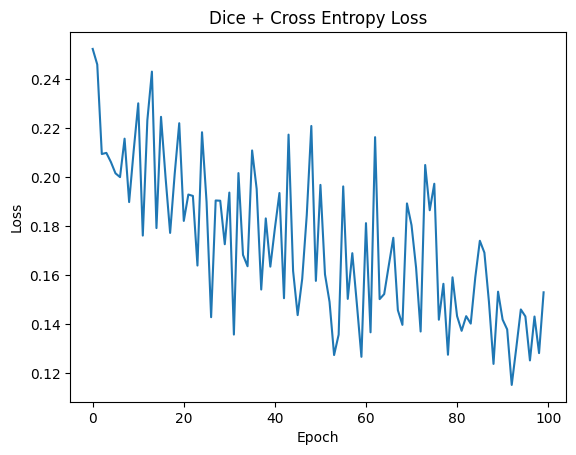

In [19]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig((model_save_path / 'train_loss.png'))
plt.close()

In [54]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=r'D:\Side_project\MedSAM\work_dir\demo2D_ICIP_2\sam_model_best.pth').to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = Path(r'D:\Side_project\MedSAM\data\gastrointestinal\test\images')
ts_gt_path = Path(r'D:\Side_project\MedSAM\data\gastrointestinal\test\labels')

test_img_list = list((ts_img_path).glob('*.png'))
test_gt_list = list((ts_gt_path).glob('*.png'))

# random select a test case
img_idx = np.random.randint(len(test_img_list))
image_data = Image.open(str(test_img_list[img_idx]))
image_data = transforms.Resize(size=(256, 256))(image_data)
image_data = np.array(image_data)
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    ratio = 256/224
    x_min = max(0, x_min*ratio - np.random.randint(0, 20))
    x_max = min(W, x_max*ratio + np.random.randint(0, 20))
    y_min = max(0, y_min*ratio - np.random.randint(0, 20))
    y_max = min(H, y_max*ratio + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = Image.open(str(test_gt_list[img_idx]))
gt_data = transforms.Resize(size=(256, 256))(gt_data)
gt_data = np.array(gt_data)
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

In [55]:
ori_sam_seg.shape

(1, 256, 256)

In [56]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
print(input_image.shape)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

torch.Size([1, 3, 1024, 1024])
bbox_raw=array([  4.85714286,  12.14285714, 156.28571429, 116.14285714]) -> bbox=array([[ 19.42857143,  48.57142857, 625.14285714, 464.57142857]])
(256, 256)


In [57]:
gt_data.shape, ori_sam_seg.shape

((256, 256), (1, 256, 256))

In [58]:
ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.3408 MedSAM DSC: 0.3435


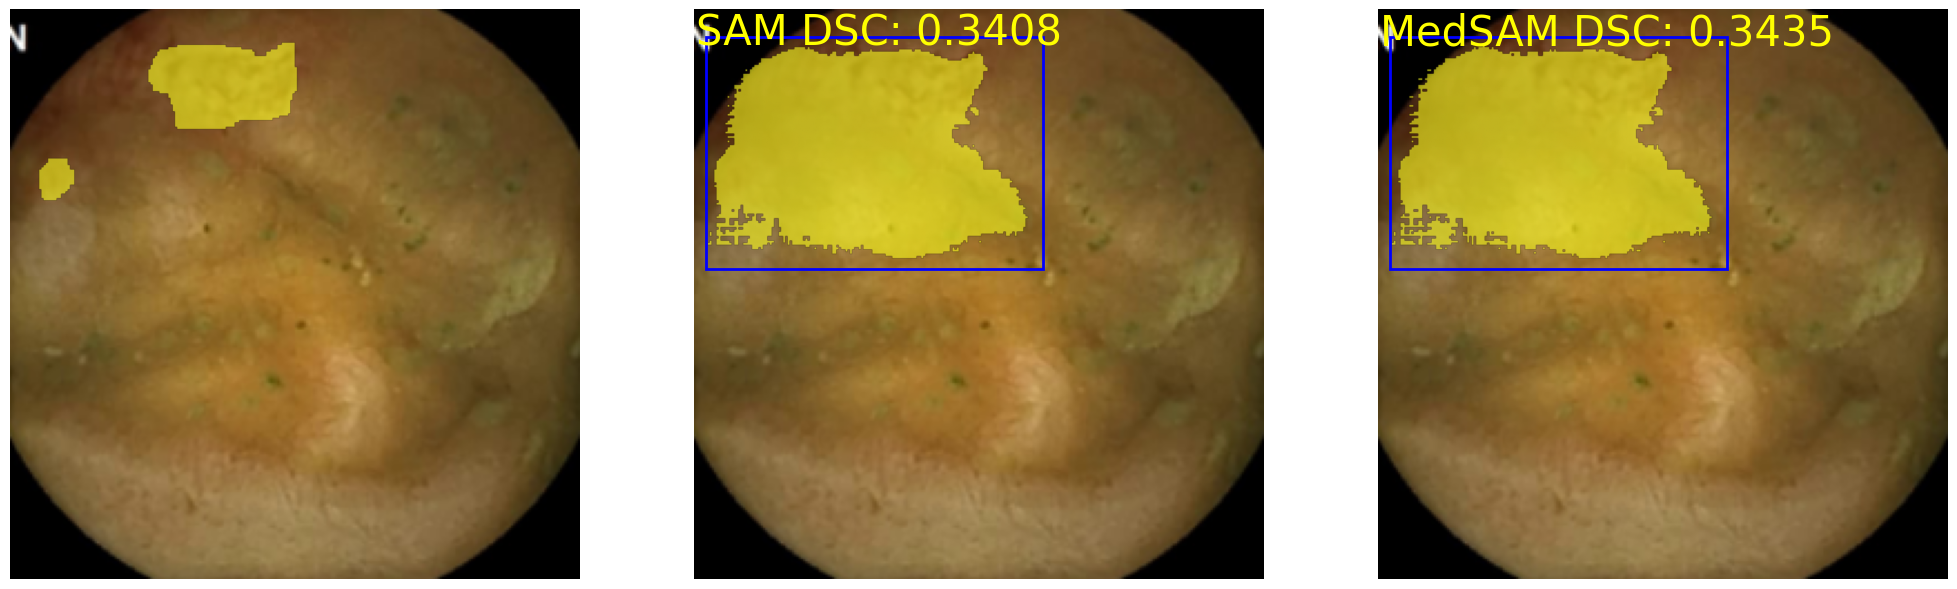

In [59]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()